#**Deep Learning Research Project**

*Incorporating attention mechanisms into CNN architectures significantly enhances model performance on image classification tasks, especially in scenarios with complex patterns or noisy backgrounds.*

# Introduction

CBAM, a simple yet effective attention module for feed-forward convolutional neural networks. It is a lightweight and general module that can be integrated into any CNN architectures seamlessly and is end-to-end trainable along with base CNNs. CBAM is used to increase representation power by using attention mechanism: focusing on important features and suppressing unnecessary ones. To achieve this, we sequentially apply channel and spatial attention modules so that each of the branches can learn 'what' and 'where' to attend in the channel and spatial axes respectively.

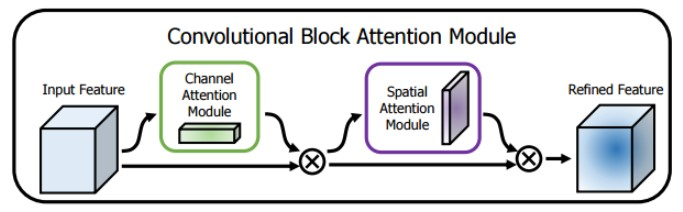

Channel Attention Module (CAM):
CAM generate a channel attention map by exploiting the inter-channel relationship of features. As each channel of a feature map is considered as a feature detector, channel attention focuses on 'what' is meaningful given an input image.

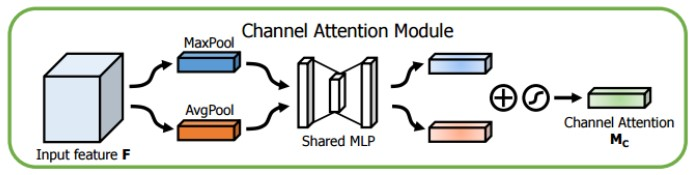

Spatial Attention Module (SAM)
SAM generate a spatial attention map by utilizing the inter-spatial relationship of features. Different from the channel attention, the spatial attention focuses on 'where' is an informative part, which is complementary to the channel attention.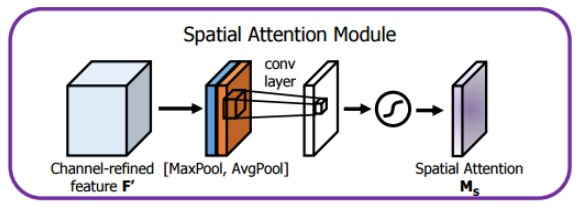


Visual Example:
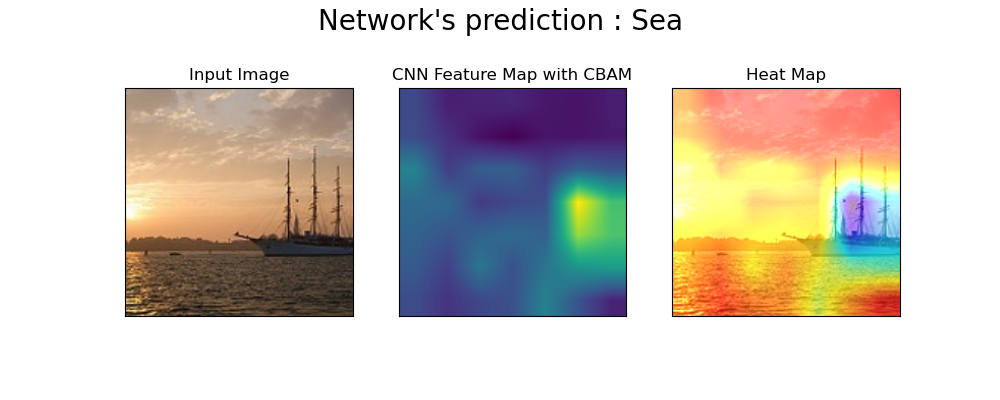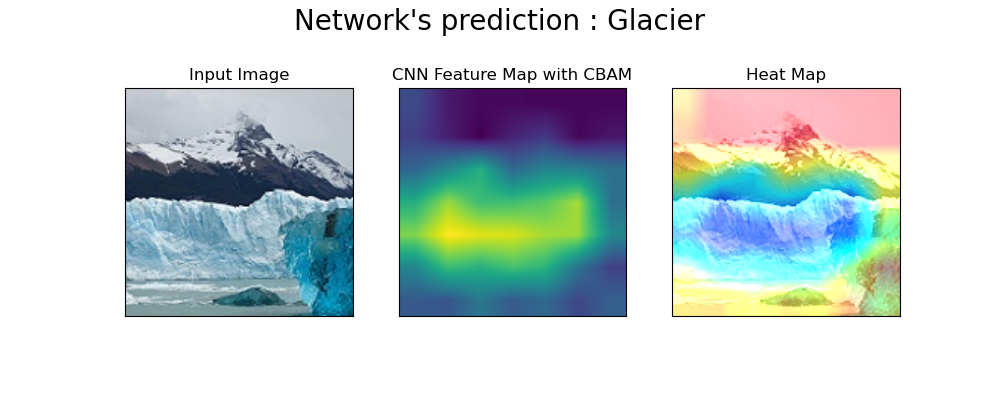

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd
import torch.utils.data
import torchvision
import torchvision.datasets as dataset
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Dataset

In [ ]:
train_dataset = dataset.CIFAR100(root="./CIFAR100/train", train=True, transform=None, download=True)

100%|██████████| 169M/169M [00:18<00:00, 9.04MB/s]


Extracting ./CIFAR100/train/cifar-100-python.tar.gz to ./CIFAR100/train


In [ ]:
x = np.concatenate([np.asarray(train_dataset[i][0]) for i in range(len(train_dataset))])
mean = np.mean(x, axis=(0, 1))/255
std = np.std(x, axis=(0,1))/255

mean = mean.tolist()
std = std.tolist()

print("mean:", mean)
print("std:", std)

mean: [0.5070751592371323, 0.48654887331495095, 0.4409178433670343]
std: [0.26733428587941854, 0.25643846292120615, 0.2761504713263903]


In [ ]:
transform = T.Compose([T.ToTensor(),
                       T.Normalize(mean, std, inplace=True)])
train_dataset = dataset.CIFAR100(root="./CIFAR100/train", train=True, transform=transform, download=True)
valid_dataset = dataset.CIFAR100(root="./CIFAR100/val", train=True, transform=transform, download=True)
test_dataset = dataset.CIFAR100(root="./CIFAR100/test", train=False, transform=transform, download=True)

Files already downloaded and verified


100%|██████████| 169M/169M [00:18<00:00, 9.19MB/s]


Extracting ./CIFAR100/val/cifar-100-python.tar.gz to ./CIFAR100/val


100%|██████████| 169M/169M [00:18<00:00, 9.07MB/s]


Extracting ./CIFAR100/test/cifar-100-python.tar.gz to ./CIFAR100/test


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
images, labels = next(iter(train_loader))

In [ ]:
print(images.shape)
print(labels.shape)
print(labels)

torch.Size([256, 3, 32, 32])
torch.Size([256])
tensor([27, 10, 73, 51, 53, 82, 21, 44, 47,  5, 94, 57, 17, 94, 92, 91, 53, 76,
        45, 46, 52, 30, 30, 85, 39, 70,  2,  6, 30, 58, 36, 67, 61, 38, 28, 10,
        61, 46, 43, 61, 27, 22, 86, 11, 43, 87, 78, 47, 97,  2, 94, 16, 79, 92,
        84,  8, 91, 35, 61, 55, 75, 42, 60, 49, 41, 96, 46, 97, 37, 34, 58,  4,
        89, 51, 92, 62, 66, 40, 95, 26, 31, 86, 33, 82, 58, 14, 68, 26, 96, 23,
        87, 82, 15, 65, 26,  3,  1, 92, 60, 32, 16, 44, 20, 86, 36, 56, 99, 61,
        72, 46, 91, 84, 89, 30, 37,  0, 69, 68, 58, 11, 46, 41, 98, 46, 15,  2,
        21, 37, 59, 79, 88, 71, 65, 70, 60, 21, 62, 92, 40, 29,  6, 48, 40, 66,
        90, 98, 44, 64, 46, 13,  6,  6, 18, 80, 33, 76, 27, 45, 11, 61, 59, 96,
        60, 25, 80, 66, 48, 87, 24,  1, 35, 56,  2, 30,  3,  7, 29, 47, 81, 23,
         2, 91, 12,  3, 40, 15, 70, 68, 25,  3, 31, 73, 10, 87, 85, 45, 74, 58,
         7, 56, 20, 84, 93, 34, 15, 45,  4, 82, 61, 42, 10, 82, 91, 46, 5

## Model

In [ ]:
# No CBAM
def conv_block(in_channels, out_channels):
    return nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(out_channels),
                         nn.ReLU())

class VGG19(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.conv_block1 = nn.Sequential(nn.Conv2d(in_channels=self.in_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         conv_block(64, 64),
                                         nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv_block2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         conv_block(128, 128),
                                         nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv_block3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         *[conv_block(256, 256) for _ in range(3)],
                                         nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv_block4 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         *[conv_block(512, 512) for _ in range(3)],
                                         nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv_block5 = nn.Sequential(*[conv_block(512, 512) for _ in range(4)],
                                         nn.MaxPool2d(kernel_size=2, stride=2))

        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(7,7))

        self.linear1 = nn.Sequential(nn.Linear(in_features=7*7*512, out_features=4096, bias=True),
                                     nn.Dropout(0.5),
                                     nn.ReLU())
        self.linear2 = nn.Sequential(nn.Linear(in_features=4096, out_features=4096, bias=True),
                                     nn.Dropout(0.5),
                                     nn.ReLU())
        self.linear3 = nn.Linear(in_features=4096, out_features=self.out_channels, bias=True)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = self.avg_pool(x)
        x = self.linear1(x.view(x.shape[0], -1))
        x = self.linear2(x)
        x = self.linear3(x)
        return x

In [ ]:
# With CBAM
class SAM(nn.Module):
    def __init__(self, bias=False):
        super(SAM, self).__init__()
        self.bias = bias
        self.conv = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=7, stride=1, padding=3, dilation=1, bias=self.bias)

    def forward(self, x):
        max = torch.max(x,1)[0].unsqueeze(1)
        avg = torch.mean(x,1).unsqueeze(1)
        concat = torch.cat((max,avg), dim=1)
        output = self.conv(concat)
        output = output * x
        return output

class CAM(nn.Module):
    def __init__(self, channels, r):
        super(CAM, self).__init__()
        self.channels = channels
        self.r = r
        self.linear = nn.Sequential(
            nn.Linear(in_features=self.channels, out_features=self.channels//self.r, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=self.channels//self.r, out_features=self.channels, bias=True))

    def forward(self, x):
        max = F.adaptive_max_pool2d(x, output_size=1)
        avg = F.adaptive_avg_pool2d(x, output_size=1)
        b, c, _, _ = x.size()
        linear_max = self.linear(max.view(b,c)).view(b, c, 1, 1)
        linear_avg = self.linear(avg.view(b,c)).view(b, c, 1, 1)
        output = linear_max + linear_avg
        output = F.sigmoid(output) * x
        return output

class CBAM(nn.Module):
    def __init__(self, channels, r):
        super(CBAM, self).__init__()
        self.channels = channels
        self.r = r
        self.sam = SAM(bias=False)
        self.cam = CAM(channels=self.channels, r=self.r)

    def forward(self, x):
        output = self.cam(x)
        output = self.sam(output)
        return output + x

def conv_block(in_channels, out_channels):
    return nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(out_channels),
                         nn.ReLU())

class VGG19_CBAM(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.conv_block1 = nn.Sequential(nn.Conv2d(in_channels=self.in_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         conv_block(64, 64),
                                         CBAM(64, r=4),
                                         nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv_block2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         conv_block(128, 128),
                                         CBAM(128, r=4),
                                         nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv_block3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         *[conv_block(256, 256) for _ in range(3)],
                                         CBAM(256, r=4),
                                         nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv_block4 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         *[conv_block(512, 512) for _ in range(3)],
                                         CBAM(512, r=4),
                                         nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv_block5 = nn.Sequential(*[conv_block(512, 512) for _ in range(4)],
                                         CBAM(512, r=4),
                                         nn.MaxPool2d(kernel_size=2, stride=2))

        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(7,7))

        self.linear1 = nn.Sequential(nn.Linear(in_features=7*7*512, out_features=4096, bias=True),
                                     nn.Dropout(0.5),
                                     nn.ReLU())
        self.linear2 = nn.Sequential(nn.Linear(in_features=4096, out_features=4096, bias=True),
                                     nn.Dropout(0.5),
                                     nn.ReLU())
        self.linear3 = nn.Linear(in_features=4096, out_features=self.out_channels, bias=True)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = self.avg_pool(x)
        x = self.linear1(x.view(x.shape[0], -1))
        x = self.linear2(x)
        x = self.linear3(x)
        return x

## Train

In [ ]:
model1 = VGG19_CBAM(in_channels=3, out_channels=100)
optimizer1 = optim.AdamW(model1.parameters(), lr=0.0001, weight_decay=0.005)
criterion1 = nn.CrossEntropyLoss()
total_epochs = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model1 = model1.to(device)

In [ ]:
model2 = VGG19(in_channels=3, out_channels=100)
optimizer2 = optim.AdamW(model2.parameters(), lr=0.0001, weight_decay=0.005)
criterion2 = nn.CrossEntropyLoss()
total_epochs = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model2 = model2.to(device)

In [ ]:
def train(model, optimizer, train_loader, val_loader, criterion, total_epochs,name):
    print("Training Begin!")
    print()
    best_accuracy = 0

    for epoch in range(total_epochs):
        model.train()

        for step, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if (step+1) % 30 == 0:
              print('Epoch: [{}/{}] | Step: [{}/{}] | Loss: {:.4f}'.format(epoch+1, total_epochs, step+1, len(train_loader), loss.item()))

        with torch.no_grad():
            print("Validating...")
            model.eval()
            total = 0
            correct = 0
            for (images, labels) in val_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

                outputs = model(images)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            acc = (correct/total)*100
            if acc > best_accuracy:
                best_accuracy = acc
                torch.save(model.state_dict(), f"./{name}.pt")
            print(f"Current Accuracy: {acc:.3f}%")
            print(f"Best Accuracy: {best_accuracy:.3f}%")
            print()

    print('Train Finished!')

In [ ]:
train(model=model1, optimizer=optimizer1, train_loader=train_loader, val_loader=valid_loader, criterion=criterion1, total_epochs=total_epochs,name="model_cbam")

Training Begin!

Epoch: [1/50] | Step: [30/196] | Loss: 4.6268
Epoch: [1/50] | Step: [60/196] | Loss: 4.6105
Epoch: [1/50] | Step: [90/196] | Loss: 4.6331
Epoch: [1/50] | Step: [120/196] | Loss: 4.5790
Epoch: [1/50] | Step: [150/196] | Loss: 4.5982
Epoch: [1/50] | Step: [180/196] | Loss: 4.6065
Validating...
Current Accuracy: 1.262%
Best Accuracy: 1.262%

Epoch: [2/50] | Step: [30/196] | Loss: 4.6030
Epoch: [2/50] | Step: [60/196] | Loss: 4.5237
Epoch: [2/50] | Step: [90/196] | Loss: 4.3829
Epoch: [2/50] | Step: [120/196] | Loss: 4.4435
Epoch: [2/50] | Step: [150/196] | Loss: 4.3231
Epoch: [2/50] | Step: [180/196] | Loss: 4.0252
Validating...
Current Accuracy: 4.454%
Best Accuracy: 4.454%

Epoch: [3/50] | Step: [30/196] | Loss: 4.0633
Epoch: [3/50] | Step: [60/196] | Loss: 4.1130
Epoch: [3/50] | Step: [90/196] | Loss: 3.9682
Epoch: [3/50] | Step: [120/196] | Loss: 3.9814
Epoch: [3/50] | Step: [150/196] | Loss: 3.9849
Epoch: [3/50] | Step: [180/196] | Loss: 4.0051
Validating...
Current 

In [ ]:
train(model=model2, optimizer=optimizer2, train_loader=train_loader, val_loader=valid_loader, criterion=criterion2, total_epochs=total_epochs,name="model_without_cbam")

Training Begin!

Epoch: [1/50] | Step: [30/196] | Loss: 4.5748
Epoch: [1/50] | Step: [60/196] | Loss: 4.4723
Epoch: [1/50] | Step: [90/196] | Loss: 4.3282
Epoch: [1/50] | Step: [120/196] | Loss: 4.2961
Epoch: [1/50] | Step: [150/196] | Loss: 4.2197
Epoch: [1/50] | Step: [180/196] | Loss: 4.2888
Validating...
Current Accuracy: 3.816%
Best Accuracy: 3.816%

Epoch: [2/50] | Step: [30/196] | Loss: 4.1095
Epoch: [2/50] | Step: [60/196] | Loss: 4.0980
Epoch: [2/50] | Step: [90/196] | Loss: 4.1120
Epoch: [2/50] | Step: [120/196] | Loss: 3.9609
Epoch: [2/50] | Step: [150/196] | Loss: 3.9700
Epoch: [2/50] | Step: [180/196] | Loss: 3.7575
Validating...
Current Accuracy: 7.750%
Best Accuracy: 7.750%

Epoch: [3/50] | Step: [30/196] | Loss: 3.8156
Epoch: [3/50] | Step: [60/196] | Loss: 3.7720
Epoch: [3/50] | Step: [90/196] | Loss: 3.6415
Epoch: [3/50] | Step: [120/196] | Loss: 3.6829
Epoch: [3/50] | Step: [150/196] | Loss: 3.7289
Epoch: [3/50] | Step: [180/196] | Loss: 3.5745
Validating...
Current 

In [ ]:
def test(model, test_loader, criterion):
    print("Evaluating Test Dataset...")
    print()
    best_accuracy = 0

    with torch.no_grad():
      model.eval()
      total = 0
      correct = 0
      count = 0

      for (images, labels) in test_loader:
          images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

          outputs = model(images)

          # top-1 accuracy
          _, predicted = torch.max(outputs, dim=1)
          total += labels.shape[0]
          correct += torch.eq(predicted, labels).sum().item()

          # top-5 accuracy
          _, predicted = torch.topk(outputs, 5)
          for gt, pred in zip(labels, predicted):
            if gt in pred:
              count += 1

      top1_acc = (correct/total)*100
      top5_acc = (count/total)*100
      print(f"Test Top-1 Accuracy: {top1_acc:.2f}%")
      print(f"Test Top-5 Accuracy: {top5_acc:.2f}%")


In [ ]:
model = VGG19(in_channels=3, out_channels=100).cuda()
model.load_state_dict(torch.load("./model_without_cbam.pt"))
test(model=model, test_loader=test_loader, criterion=criterion1) # No CBAM

<ipython-input-18-2398b5254bfc>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./model_without_cbam.pt"))


Evaluating Test Dataset...



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Top-1 Accuracy: 41.26%
Test Top-5 Accuracy: 68.84%


In [ ]:
model = VGG19_CBAM(in_channels=3, out_channels=100).cuda()
model.load_state_dict(torch.load("./model_cbam.pt"))
test(model=model, test_loader=test_loader, criterion=criterion2) # With CBAM

<ipython-input-19-c2621f12620e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./model_cbam.pt"))


Evaluating Test Dataset...

Test Top-1 Accuracy: 41.80%
Test Top-5 Accuracy: 69.43%
